In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-f80e9374-504a-571b-bac0-6fb00750db4c"

In [2]:
import os
import numpy as np
from collections import defaultdict
import gzip
import pandas as pd
import torch
import pyBigWig

import sys

sys.path.append("../2_train_models")
from data_loading import read_fasta_fast, one_hot_encode, extract_peaks, extract_observed_profiles
from file_configs import FoldFilesConfig, MergedFilesConfig

sys.path.append("../3_eval_models")
from eval_utils import model_predict_with_rc

sys.path.append('../4_interpret_models')
from captum.attr import DeepLiftShap
from deepshap_utils import ProfileModelWrapper
from dinuc_shuffle import dinuc_shuffle

sys.path.append("../5_modisco")
from modiscolite_utils import load_scores, load_modisco_results

from plot_utils import get_continuous_cmap
from other_motif_utils import trim_two_motifs_by_thresh, plot_motif_on_ax, compute_per_position_ic

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# all sets of models we trained, based on available ENCODE data
cell_types = ["K562", "A673", "CACO2", "CALU3", "HUVEC", "MCF10A"]

# the unique IDs for each of the folds / models in each cell type
timestamps = {"K562" : ["2023-05-29_15-51-40", "2023-05-29_15-58-41", "2023-05-29_15-59-09",
                        "2023-05-30_01-40-06", "2023-05-29_23-21-23", "2023-05-29_23-23-45",
                        "2023-05-29_23-24-11"],
              "A673" : ["2023-06-11_20-11-32","2023-06-11_23-42-00", "2023-06-12_03-29-06",
                        "2023-06-12_07-17-43", "2023-06-12_11-10-59", "2023-06-12_14-36-40",
                        "2023-06-12_17-26-09"],
              "CACO2" : ["2023-06-12_21-46-40", "2023-06-13_01-28-24", "2023-06-13_05-06-53",
                         "2023-06-13_08-52-39", "2023-06-13_13-12-09", "2023-06-13_16-40-41",
                         "2023-06-13_20-08-39"],
              "CALU3" : ["2023-06-14_00-43-44", "2023-06-14_04-26-48", "2023-06-14_09-34-26",
                         "2023-06-14_13-03-59", "2023-06-14_17-22-28", "2023-06-14_21-03-11",
                         "2023-06-14_23-58-36"],
              "HUVEC" : ["2023-06-16_21-59-35", "2023-06-17_00-20-34", "2023-06-17_02-17-07",
                         "2023-06-17_04-27-08", "2023-06-17_06-42-19", "2023-06-17_09-16-24",
                         "2023-06-17_11-09-38"],
              "MCF10A" : ["2023-06-15_06-07-40", "2023-06-15_10-37-03", "2023-06-15_16-23-56",
                          "2023-06-15_21-44-32", "2023-06-16_03-47-46", "2023-06-16_09-41-26",
                          "2023-06-16_15-07-01"]}

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

## Subfigure A: MYC example

In [4]:
# Load the config objects (filepaths holders) for each fold a model was trained on

def load_fold_configs(cell_type, timestamps,
                      model_type = model_type, data_type = data_type):

    fold_configs = []
    for fold_i, timestamp in enumerate(timestamps):
        # folds are 1-indexed, and config constructor is expecting a string
        fold = str(fold_i + 1)
        
        # load the config object for this specific fold / model
        config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        fold_configs.append(config)
        
    return fold_configs

fold_configs = { cell_type : load_fold_configs(cell_type, timestamps[cell_type]) for cell_type in cell_types }

Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11
Timestamp: 2023-06-11_20-11-32
Timestamp: 2023-06-11_23-42-00
Timestamp: 2023-06-12_03-29-06
Timestamp: 2023-06-12_07-17-43
Timestamp: 2023-06-12_11-10-59
Timestamp: 2023-06-12_14-36-40
Timestamp: 2023-06-12_17-26-09
Timestamp: 2023-06-12_21-46-40
Timestamp: 2023-06-13_01-28-24
Timestamp: 2023-06-13_05-06-53
Timestamp: 2023-06-13_08-52-39
Timestamp: 2023-06-13_13-12-09
Timestamp: 2023-06-13_16-40-41
Timestamp: 2023-06-13_20-08-39
Timestamp: 2023-06-14_00-43-44
Timestamp: 2023-06-14_04-26-48
Timestamp: 2023-06-14_09-34-26
Timestamp: 2023-06-14_13-03-59
Timestamp: 2023-06-14_17-22-28
Timestamp: 2023-06-14_21-03-11
Timestamp: 2023-06-14_23-58-36
Timestamp: 2023-06-16_21-59-35
Timestamp: 2023-06-17_00-20-34
Timestamp: 2023-06-17_02-17-07
Timestamp: 2023-06-17_04-27-08
Timestam

In [5]:
# these paths aren't specific to any model / fold, cell type, or data_type

proj_dir = fold_configs["K562"][0].proj_dir

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

In [6]:
### Data Loading

def load_sequence_at_locus(chrom, start, end, config, in_window=in_window):
    genome_path = config.genome_path
    
    # calculate sequence coordinates so they'll match model input size
    mid = (start + end) // 2
    seq_start = mid - in_window // 2
    seq_end = seq_start + in_window
    
    # load (forward strand) genomic sequence between start and end coords
    genome = read_fasta_fast(genome_path, include_chroms = [chrom])
    # seq is a string
    seq = genome[chrom][seq_start:seq_end]
    
    # one-hot encode the sequence string (returns numpy array)
    onehot_seq = one_hot_encode(seq).T
    
    # after transposing, onehot_seq is shape (4, end - start)
    return seq, onehot_seq


def load_observed_profile_at_locus(chrom, start, end, plus_bw_path, minus_bw_path):
    # load the positive-strand PRO-cap data between the start and end coords
    with pyBigWig.open(plus_bw_path, "r") as plus_bw:
        plus_sig = plus_bw.values(chrom, start, end, numpy=True)
    plus_sig = np.nan_to_num(plus_sig)

    # repeat for the negative strand
    with pyBigWig.open(minus_bw_path, "r") as minus_bw:
        minus_sig = minus_bw.values(chrom, start, end, numpy=True)
    minus_sig = np.nan_to_num(minus_sig)

    # combine into array of shape (2, end - start)
    signal = np.array([plus_sig, minus_sig])
    return signal


def get_locus_data(chrom, start, end, config, out_window=out_window):
    # loads observed data, *centered* between start and end coords
    
    genome_path = config.genome_path
    plus_bw_path = config.plus_bw_path
    minus_bw_path = config.minus_bw_path
    
    # calculate profile coordinates so they'll match model output size
    mid = (start + end) // 2
    prof_start = mid - out_window // 2
    prof_end = prof_start + out_window
    prof = load_observed_profile_at_locus(chrom, prof_start, prof_end,
                                          plus_bw_path, minus_bw_path)
    
    return prof


# The example we will plot: MYC promoter coordinates
chrom, start, end = ["chr8", 127735875, 127736475]

# Load everything before doing any motif ablation (og = original)
og_seq, og_onehot_seq = load_sequence_at_locus(chrom, start, end, fold_configs["K562"][0])
og_profs = { cell_type : get_locus_data(chrom, start, end, fold_configs[cell_type][0]) for cell_type in cell_types }

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


In [10]:
### Model Prediction

def load_model(config):
    model = torch.load(config.model_save_path)
    model.eval()
    model = model.cuda()
    return model

def predict_merge_across_folds(onehot_seq, fold_configs):
    pred_profs_across_folds = []
    pred_logcounts_across_folds = []
    
    #onehot_seq = torch.tensor(onehot_seq, dtype=torch.float32)
    onehot_seq = onehot_seq[None,...]
    
    # for each fold model...
    for config in fold_configs:
        model = load_model(config)
        
        with torch.no_grad():
            pred_profs, pred_logcounts = model_predict_with_rc(model, onehot_seq)

        pred_prof = np.exp(pred_profs.squeeze())
        pred_profs_across_folds.append(pred_prof)
        pred_logcounts_across_folds.append(pred_logcounts)
        
    # take the mean prediction across all folds
    merged_pred_prof = np.array(pred_profs_across_folds).mean(axis=0)
    merged_pred_logcounts = np.array(pred_logcounts_across_folds).mean(axis=0)
    
    # combine profile and counts outputs into one prediction
    scaled_pred_prof = merged_pred_prof * np.exp(merged_pred_logcounts)
    return scaled_pred_prof


def deepshap(seq, model):
    # run deepshap on a single sequence
    # this function uses the profile task by default (cleaner scores)
    
    prof_shap_explainer = DeepLiftShap(ProfileModelWrapper(model))
    
    if len(seq.shape) < 3:
        seq = seq[None,...]

    # reference will be 25 dinucleotide-shuffled sequences
    ref_seqs = dinuc_shuffle(seq[0], 25).float().cuda()
    prof_attrs = prof_shap_explainer.attribute(seq.cuda(), ref_seqs).cpu()
    
    # project scores onto the sequence
    prof_attrs = prof_attrs * seq
    
    return prof_attrs.squeeze().detach().numpy()


def deepshap_merge_across_folds(onehot_seq, fold_configs):
    prof_deepshap_across_folds = []
    
    onehot_seq = torch.tensor(onehot_seq).float()
    
    # for each fold model...
    for config in fold_configs:
        model = load_model(config)
        scores = deepshap(onehot_seq, model)
        prof_deepshap_across_folds.append(scores)

    # take mean of scores across all model folds
    merged_prof_deepshap = np.array(prof_deepshap_across_folds).mean(axis=0)
    return merged_prof_deepshap


pred_profs = dict()
prof_attrs = dict()
for cell_type in cell_types:
    # get model prediction on genomic sequence
    pred_profs[cell_type] = predict_merge_across_folds(og_onehot_seq, fold_configs[cell_type])
    # get profile contribution scores
    prof_attrs[cell_type] = deepshap_merge_across_folds(og_onehot_seq, fold_configs[cell_type])

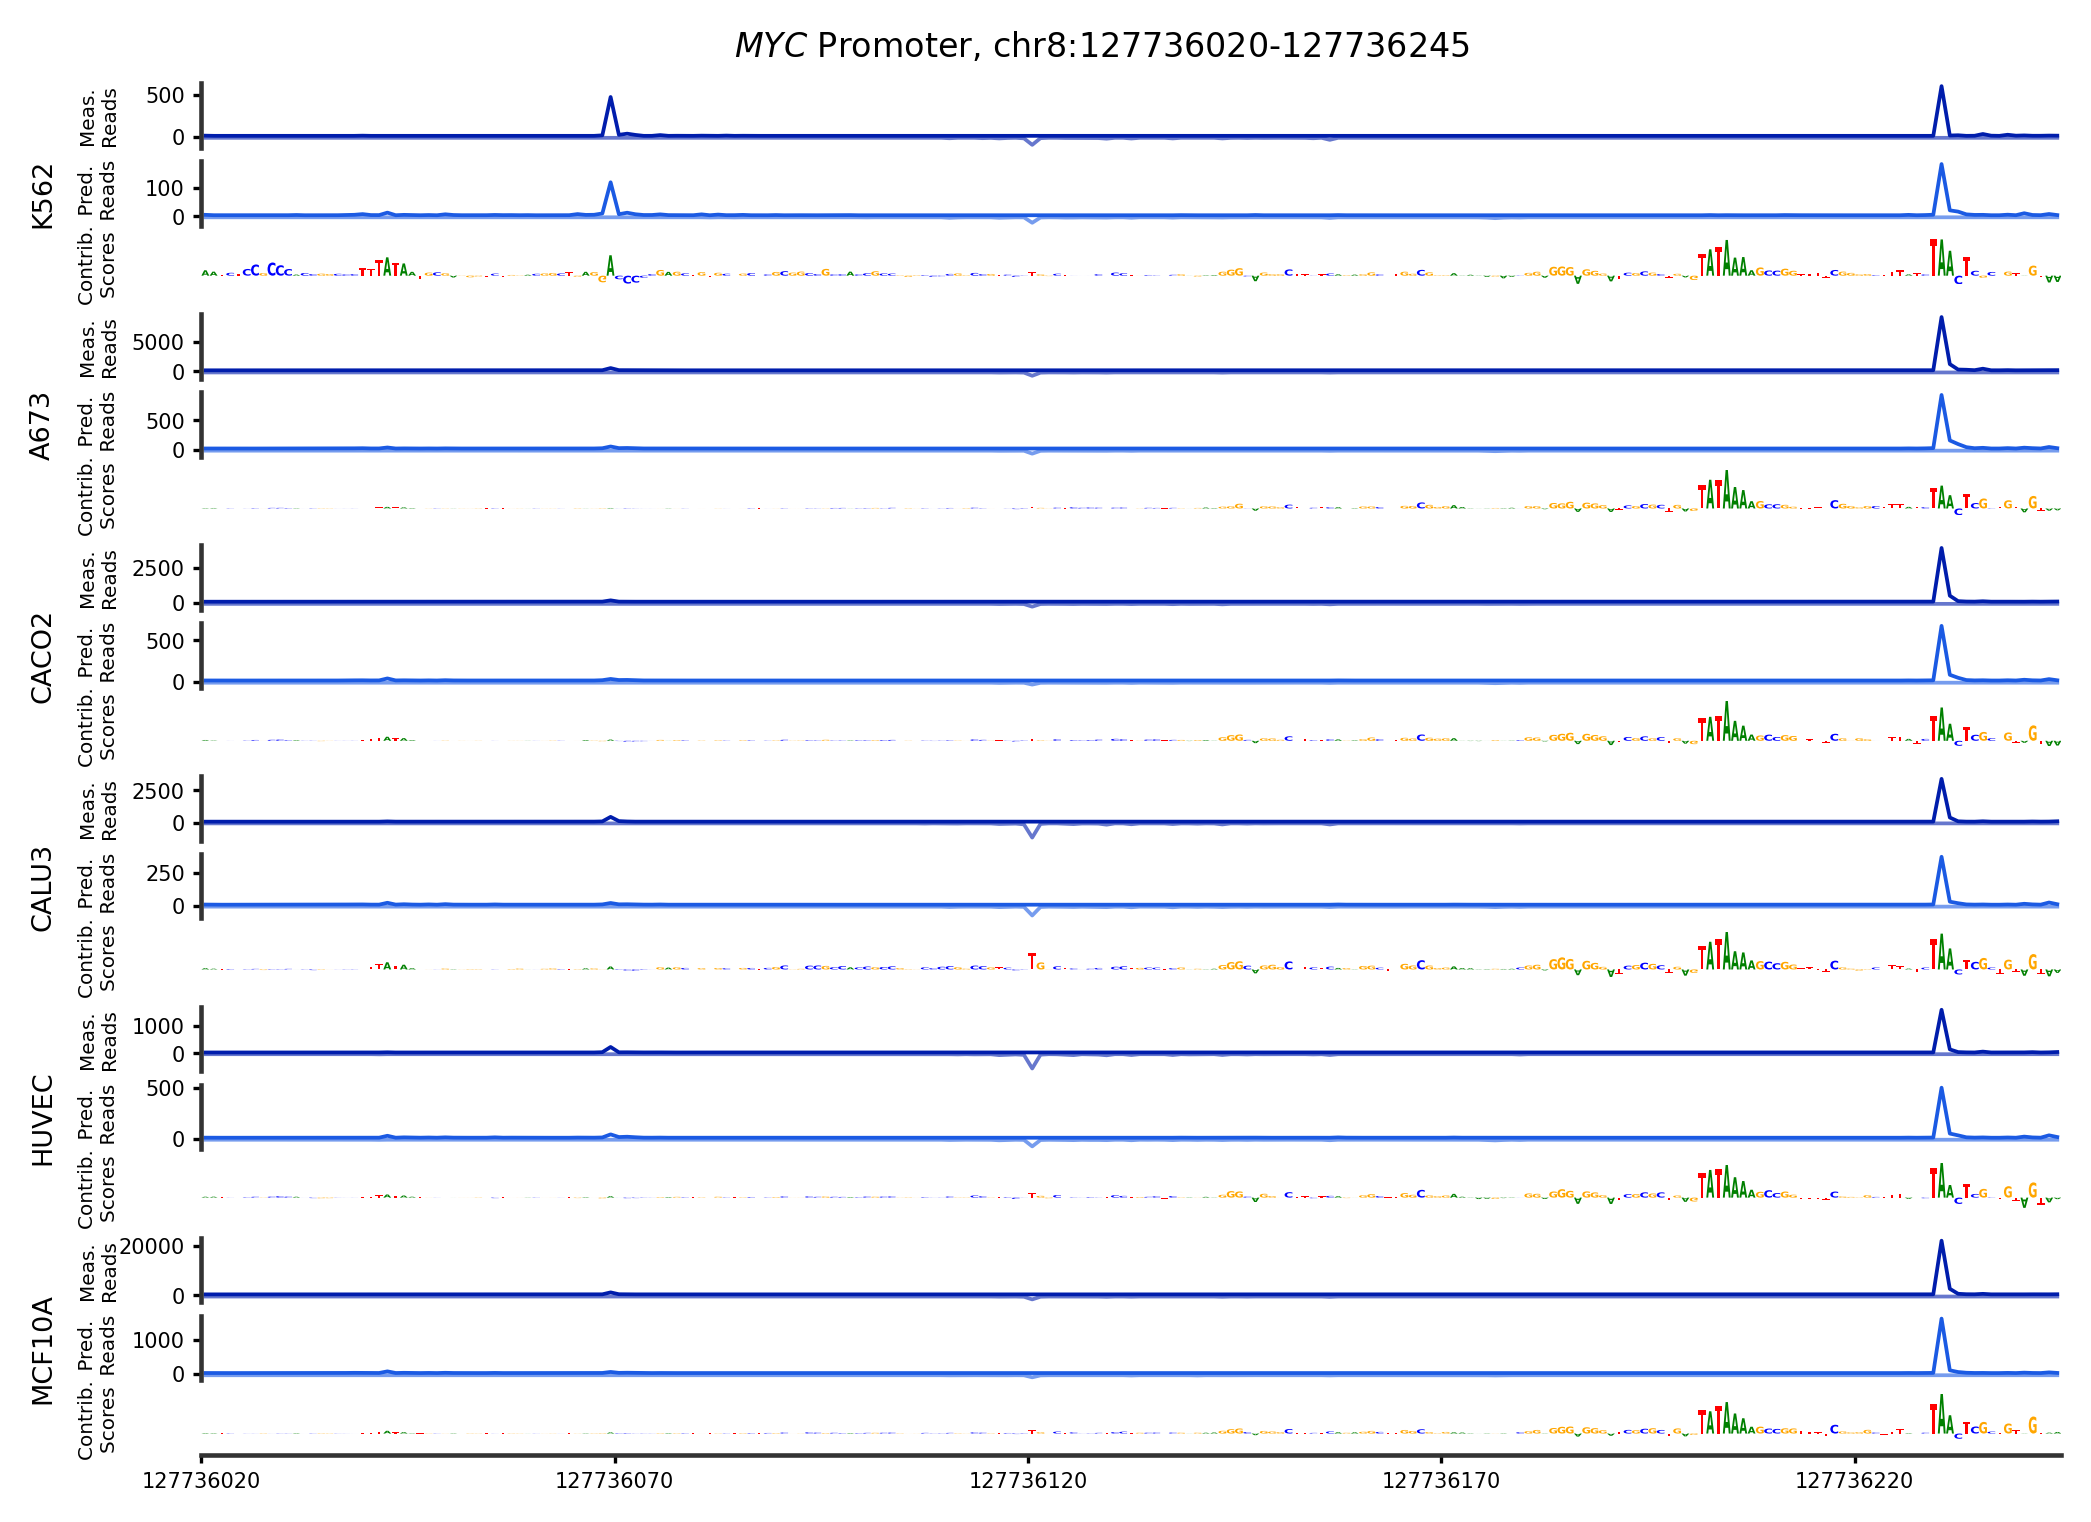

In [12]:
def slice_to_prof_len(attrs, prof_len = out_window):
    # Attributions are along the sequence axis, so their length
    # is the same as the model input. For plots, we want them to
    # be trimmed to the size of the model output instead.
    
    # lazy check that we have the right axis
    assert attrs.shape[-1] >= prof_len, attrs.shape
    
    # center the trimming
    mid = attrs.shape[-1] / 2
    prof_start = int(mid - prof_len / 2)
    prof_end = prof_start + prof_len
    
    return attrs[..., prof_start : prof_end]


def plot_prof_on_ax(profile, ax, zoom_start, zoom_end,
                    color = "#001DAC", alphas = [1, 0.6],
                    linewidth=0.9, x_axis_buffer=0):
    
    # the + 0.5 is so the profiles are right on top of the bases of the scores
    x_range = np.arange(zoom_start, zoom_end) + 0.5
    
    # when both strands have data at 0, they'll plot on top of each other.
    # this offset is the minimum needed to uniformly add to the plotting
    # of both strands so that when the lines are at 0, they're both still visible
    offset = np.max(np.abs(profile[:, zoom_start:zoom_end])) * 0.02
    
    # plot positive strand
    ax.plot(x_range, profile[0, zoom_start:zoom_end] + offset,
            alpha = alphas[0], c = color, linewidth=linewidth)
    # plot negative strand
    ax.plot(x_range, -1 * profile[1, zoom_start:zoom_end] - offset,
            alpha = alphas[1], c = color, linewidth=linewidth)

    ax.set_xlim(zoom_start - x_axis_buffer, zoom_end + x_axis_buffer)
    
    
def get_prof_plot_lims(profs, zoom_start, zoom_end):
    # figure out what the range of the y-axis should be, so that
    # it includes the most extreme values in every profile we will plot
    
    pos_strand_max = 0
    neg_strand_max = 0
    
    # figure out the maximum across any profile, for each strand
    for prof in profs:
        pos_strand_max = max(pos_strand_max, np.max(prof[0, zoom_start:zoom_end]))
        neg_strand_max = max(neg_strand_max, np.max(prof[1, zoom_start:zoom_end]))
    
    return -1 * neg_strand_max, pos_strand_max 


def get_attr_plot_lims(attrs, zoom_start, zoom_end):
    # same as get_prof_plot_lims() but for the contribution score tracks
    
    # we don't have two strands, but values can be positive or negative
    pos_max = 0
    neg_max = 0
    
    for attr in attrs:
        attr = slice_to_prof_len(attr)
        pos_max = max(pos_max, np.max(attr[:, zoom_start:zoom_end]))
        neg_max = min(neg_max, np.min(attr[:, zoom_start:zoom_end]))
    return neg_max, pos_max


def plot_MYC_example_all_cell_types(og_seq, og_onehot_seq,
                                  true_profs, pred_profs, all_attrs,
                                  cell_types,
                                  prof_len = out_window, save_path = None,
                                  zoom_midpoint = 457, zoom_width = 225):
    
    assert len(true_profs) == len(true_profs), (len(mutate_pred_profs), len(pred_profs))
    assert len(true_profs) == len(all_attrs), (len(true_profs), len(all_attrs))
    assert len(true_profs) == len(cell_types), (len(true_profs), len(cell_types))
    
    plot_params = {"xtick.labelsize": 8, "ytick.labelsize": 8}
    plt.rcParams.update(plot_params)
    axis_fontsize = 4.8
    axis_labelpad = 0
    axis_index = 0
    
    
    # total plot-rows: (original data, pred, and scores) for each cell type
    num_subplots = 3 * len(cell_types)
    
    # BUT to put spacing between each cell type's rows, we will have an extra insivible thin row
    num_actual_subplots = 4 * len(cell_types)
    
    # [10,10,7,1] --> (original data, pred, scores, spacer)
    height_ratios = [10,10,7,0.5] * len(cell_types)
    
    
    fig = plt.figure(figsize=(8, 0.33 * num_subplots), dpi=300)
    gs = fig.add_gridspec(num_actual_subplots, height_ratios = height_ratios, hspace=0.3)
    axes = gs.subplots()

    # use eyeballs to figure out what exact bases you want to plot
    # plto will show region that is (zoom_midpoint - zoom_width/2, zoom_midpoint + zoom_width/2)
    zoom_start = min(max(zoom_midpoint - zoom_width//2, 0), prof_len - zoom_width)
    zoom_end = zoom_start + zoom_width
    genomic_start = (start + end) // 2 - out_window // 2
    
    title = r'$\it{MYC}$ Promoter, '
    title += chrom + ":" + str(genomic_start + zoom_start) + "-" + str(genomic_start + zoom_end)
    fig.suptitle(title, y = 0.91, fontsize=8, horizontalalignment='center')
    
    # figure out what you want the y-axis range of the predicted profiles to consistently be
    pred_prof_min, pred_prof_max = get_prof_plot_lims(pred_profs.values(),
                                                      zoom_start, zoom_end)
    
    # repeat for attributions
    attr_min, attr_max = get_attr_plot_lims(all_attrs.values(), zoom_start, zoom_end)
    
    
    # repeat for all of the sequence mutations: plot obs, predicted profiles + scores
    
    for cell_type in cell_types:
        true_prof = true_profs[cell_type]
        pred_prof = pred_profs[cell_type]
        attrs = all_attrs[cell_type]
        
        # skip the invisible spacer axis
        if axis_index > 0:
            axis_index += 1
        
        # plot original observed data
    
        plot_prof_on_ax(true_prof, axes[axis_index], zoom_start, zoom_end,
                        color = "#001DAC")

        axes[axis_index].set_ylabel("Meas.\nReads", fontsize = axis_fontsize,
                                    rotation=90, labelpad=axis_labelpad)
        axis_index += 1
        
        # plot model prediction

        plot_prof_on_ax(pred_prof, axes[axis_index], zoom_start, zoom_end,
                        color = "#1B5AE3")
        
        axes[axis_index].set_ylabel(" Pred.\n Reads", fontsize = axis_fontsize,
                                    rotation=90, labelpad=axis_labelpad)
        
        # add the outer-y-axis-label looking text
        label_ax = axes[axis_index].twinx()
        label_ax.spines[:].set_visible(False)
        label_ax.set_yticks([])
        label_ax.yaxis.set_label_position('left')
        label_ax.set_ylabel(cell_type, fontsize=6.5, labelpad=15)
        
        axis_index += 1
        
        # plot contribution scores
        
        attrs = slice_to_prof_len(attrs)[:, zoom_start : zoom_end].T
        plot_motif_on_ax(attrs, axes[axis_index])
        
        axes[axis_index].set_ylabel("Contrib. \nScores ",
                                    fontsize = axis_fontsize, rotation=90,
                                    labelpad=axis_labelpad)
        
        axis_index += 1
        
    
    # aesthetics below
    
    # fix off-by-one error from loop above (no spacing subplot after last set of subplots)
    axis_index -= 1 
    
    xticks = np.arange(0, zoom_end - zoom_start, 50)
    xticklabels = np.array([int(tick_pos + zoom_start + genomic_start) for tick_pos in xticks])

    for ax_i, ax in enumerate(axes):
        ax.tick_params(length=2, pad=2, labelsize=5)
        
        if height_ratios[ax_i] == min(height_ratios):  # is this one of the spacing subplots?
            ax.spines["left"].set_visible(False)
            ax.set_yticks([])
        else:
            ax.spines["left"].set_linewidth(1.1)
            ax.spines["left"].set_color("#333333")
        ax.spines[["top", "right"]].set_visible(False)
        
        if ax_i == len(axes) - 1:
            ax.set_xlim(0, zoom_end - zoom_start)
            ax.set_xticks(xticks, xticklabels)
            ax.spines["bottom"].set_linewidth(1.1)
            ax.spines["bottom"].set_color("#333333")
        else:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
    
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)

    plt.show()

    
plot_MYC_example_all_cell_types(og_seq, og_onehot_seq,
                              og_profs, pred_profs, prof_attrs,
                              cell_types,
                              prof_len = out_window,
                              save_path = figures_dir + "celltypes_myc.png")

## Subfigures B and C: Modisco Results

In [4]:
new_motifs_info = [["ATF4", "A673", "pos", "profile", 15],
                   ["HNF1A/B", "CACO2", "pos", "profile", 13],
                   ["TEAD", "CACO2", "pos", "profile", 8],
                   ["FOX", "CACO2", "pos", "profile", 31],
                   ["HNF4A/G", "CACO2", "pos", "profile", 16],
                   ["CEBP", "MCF10A", "pos", "profile", 27],
                   ["RFX", "MCF10A", "pos", "profile", 30],
                   ["IRF/STAT", "CALU3", "pos", "counts", 12],
                   ["EWS-FLI", "A673", "pos", "counts", 10],
                   ["SNAI", "A673", "neg", "counts", 1],
                   ["GRHL1", "CACO2", "pos", "counts", 27]]

In [5]:
cell_types = ["K562", "A673", "CACO2", "CALU3", "HUVEC", "MCF10A"]

# need to specify which patterns were which motifs for every expt

motif_names = ["SP1/BRE", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA",
               "ATF4", "HNF1A/B", "TEAD", "FOX", "HNF4A/G", "CEBP", "RFX", "IRF/STAT", "EWS-FLI",
               "SNAI", "GRHL1"]

In [6]:
motifs_to_patterns = dict()

motifs_to_patterns["K562"]   = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
motifs_to_patterns["A673"]   = [3,0,5,4,11,7,6,17,13,12,16,20,22,19,np.nan,15,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
motifs_to_patterns["CACO2"]  = [1,0,5,3,6,4,7,14,10,12,11,15,17,25,22,19,13,8,31,16,np.nan,np.nan]
motifs_to_patterns["CALU3"]  = [1,0,3,4,9,6,13,14,10,5,27,18,17,np.nan,np.nan,np.nan,15,np.nan,np.nan,np.nan,np.nan,np.nan]
motifs_to_patterns["HUVEC"]  = [2,0,1,3,8,6,12,16,13,4,15,23,18,np.nan,20,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
motifs_to_patterns["MCF10A"] = [2,0,6,4,8,5,15,16,14,1,11,18,19,21,np.nan,10,np.nan,np.nan,np.nan,np.nan,27,30]

In [7]:
proj_dir = MergedFilesConfig("K562", model_type, data_type).proj_dir
figures_dir = proj_dir + "figures/"

In [8]:
configs = { cell_type : MergedFilesConfig(cell_type, model_type, data_type) for cell_type in cell_types }

In [9]:
import h5py
from collections import defaultdict


def load_motif_pfms_cwms(modisco_results_path, include = None):
    new_f = h5py.File(modisco_results_path, "r")
    
    pfms = defaultdict(lambda : dict())
    cwms = defaultdict(lambda : dict())
    for patterns_group_name in ['pos_patterns', 'neg_patterns']:
        if patterns_group_name in new_f.keys():
            new_patterns_grp = new_f[patterns_group_name]
            
            print(patterns_group_name, " - ", len(new_patterns_grp.keys()), "motifs")
            
            if len(new_patterns_grp.keys()) > 0:
                pattern_names = list(new_patterns_grp.keys())
                pattern_names = sorted(pattern_names, key = lambda name : int(name.split("_")[1]))
                
                for pattern in pattern_names:
                    if include is not None and patterns_group_name in include.keys():
                        if int(pattern.replace("pattern_", "")) not in include[patterns_group_name]:
                            continue
                    
                    pattern_grp = new_patterns_grp[pattern]
                    sequence = pattern_grp["sequence"]
                    contrib_scores = pattern_grp["contrib_scores"]
                    hypothetical_contribs = pattern_grp["hypothetical_contribs"]
                    
                    pfms[patterns_group_name][pattern] = sequence[:]
                    cwms[patterns_group_name][pattern] = contrib_scores[:]
                    
    new_f.close()
    
    return pfms, cwms

pfms = dict()
cwms = dict()

for cell_type in cell_types:
    pfms[cell_type], cwms[cell_type] = load_motif_pfms_cwms(configs[cell_type].modisco_profile_results_path)

pos_patterns  -  43 motifs
neg_patterns  -  3 motifs
pos_patterns  -  43 motifs
pos_patterns  -  43 motifs
pos_patterns  -  36 motifs
pos_patterns  -  31 motifs
pos_patterns  -  36 motifs


In [10]:
pfms_counts = dict()
cwms_counts = dict()

for cell_type in cell_types:
    pfms_counts[cell_type], cwms_counts[cell_type] = load_motif_pfms_cwms(configs[cell_type].modisco_counts_results_path)

pos_patterns  -  33 motifs
neg_patterns  -  16 motifs
pos_patterns  -  24 motifs
neg_patterns  -  2 motifs
pos_patterns  -  41 motifs
neg_patterns  -  1 motifs
pos_patterns  -  24 motifs
neg_patterns  -  1 motifs
pos_patterns  -  26 motifs
pos_patterns  -  39 motifs


In [11]:
import logomaker
from other_motif_utils import trim_two_motifs_by_thresh, compute_per_position_ic

def plot_motif_on_ax(array, ax, ylabel=None):
    assert len(array.shape) == 2 and array.shape[-1] == 4, array.shape
 
    # reformat pwm to what logomaker expects
    df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # plot motif ("baseline_width=0" removes the y=0 line)
    crp_logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    crp_logo.style_spines(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])

    if ylabel is not None:
        ax.set_title(ylabel, y=1.1, fontsize=6)

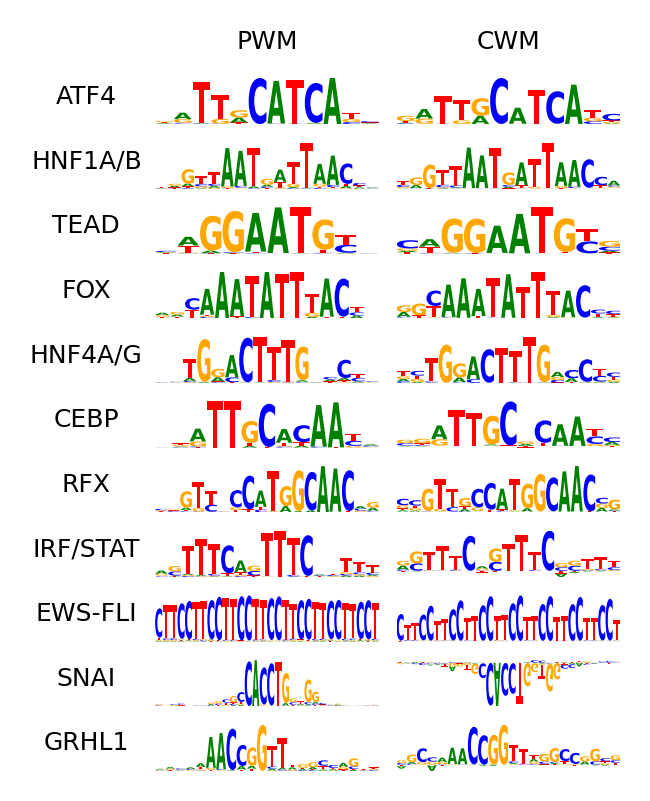

In [21]:
fig, axes = plt.subplots(len(new_motifs_info), 2, figsize=(2, 3), dpi=300)

for ax_i, motif_info in enumerate(new_motifs_info):
    motif_name, cell_type, pattern_type, task, pattern_i = motif_info
    assert task in ["profile", "counts"], task
 
    if task == "counts":
        pfm = pfms_counts[cell_type][pattern_type + "_patterns"]["pattern_" + str(pattern_i)]
        cwm = cwms_counts[cell_type][pattern_type + "_patterns"]["pattern_" + str(pattern_i)]
    else:
        pfm = pfms[cell_type][pattern_type + "_patterns"]["pattern_" + str(pattern_i)]
        cwm = cwms[cell_type][pattern_type + "_patterns"]["pattern_" + str(pattern_i)]
        
    pwm = pfm * compute_per_position_ic(pfm)[:, None]
    pwm_trim, cwm_trim = trim_two_motifs_by_thresh(pwm, cwm)
    
    if ax_i == 0:
        plot_motif_on_ax(pwm_trim, axes[ax_i][0], "PWM")
        plot_motif_on_ax(cwm_trim, axes[ax_i][1], "CWM")
    else:
        plot_motif_on_ax(pwm_trim, axes[ax_i][0])
        plot_motif_on_ax(cwm_trim, axes[ax_i][1])

    axes[ax_i][0].set_ylabel(motif_name, fontsize=6,
                                labelpad=13, rotation=0, y=0.35)
    


plt.subplots_adjust(wspace=0.1 * 0.8, hspace=0.5 * 0.8)

plt.savefig(figures_dir + "celltypes_newmotifs.png",
            bbox_inches = 'tight', pad_inches = 0, dpi = 300)

plt.show()

In [15]:
### Load Motifs

from motif_hits_utils import load_motif_hits
from collections import defaultdict


def remove_duplicate_motif_hits(hits):
    # removes motif hits called twice, across two different peaks
    hits = hits[["chrom", "start", "end", "motif"]]
    return hits.drop_duplicates().reset_index(drop=True)
    

all_motif_hit_counts = defaultdict(lambda : dict())

for cell_type in cell_types:
    hits, _, _ = load_motif_hits(cell_type, model_type, data_type, in_window)
    
    for task in ["profile", "counts"]:
        cleaned_hits = remove_duplicate_motif_hits(hits[task])
        
        raw_hit_counts = np.unique(cleaned_hits["motif"], return_counts=True)
        
        hit_counts = defaultdict(lambda : np.nan)
        for motif_name, num_hits in zip(*raw_hit_counts):
            if motif_name == "BRE/SP":
                hit_counts["SP1/BRE"] = num_hits
            else:
                hit_counts[motif_name] = num_hits
        
        all_motif_hit_counts[cell_type][task] = hit_counts

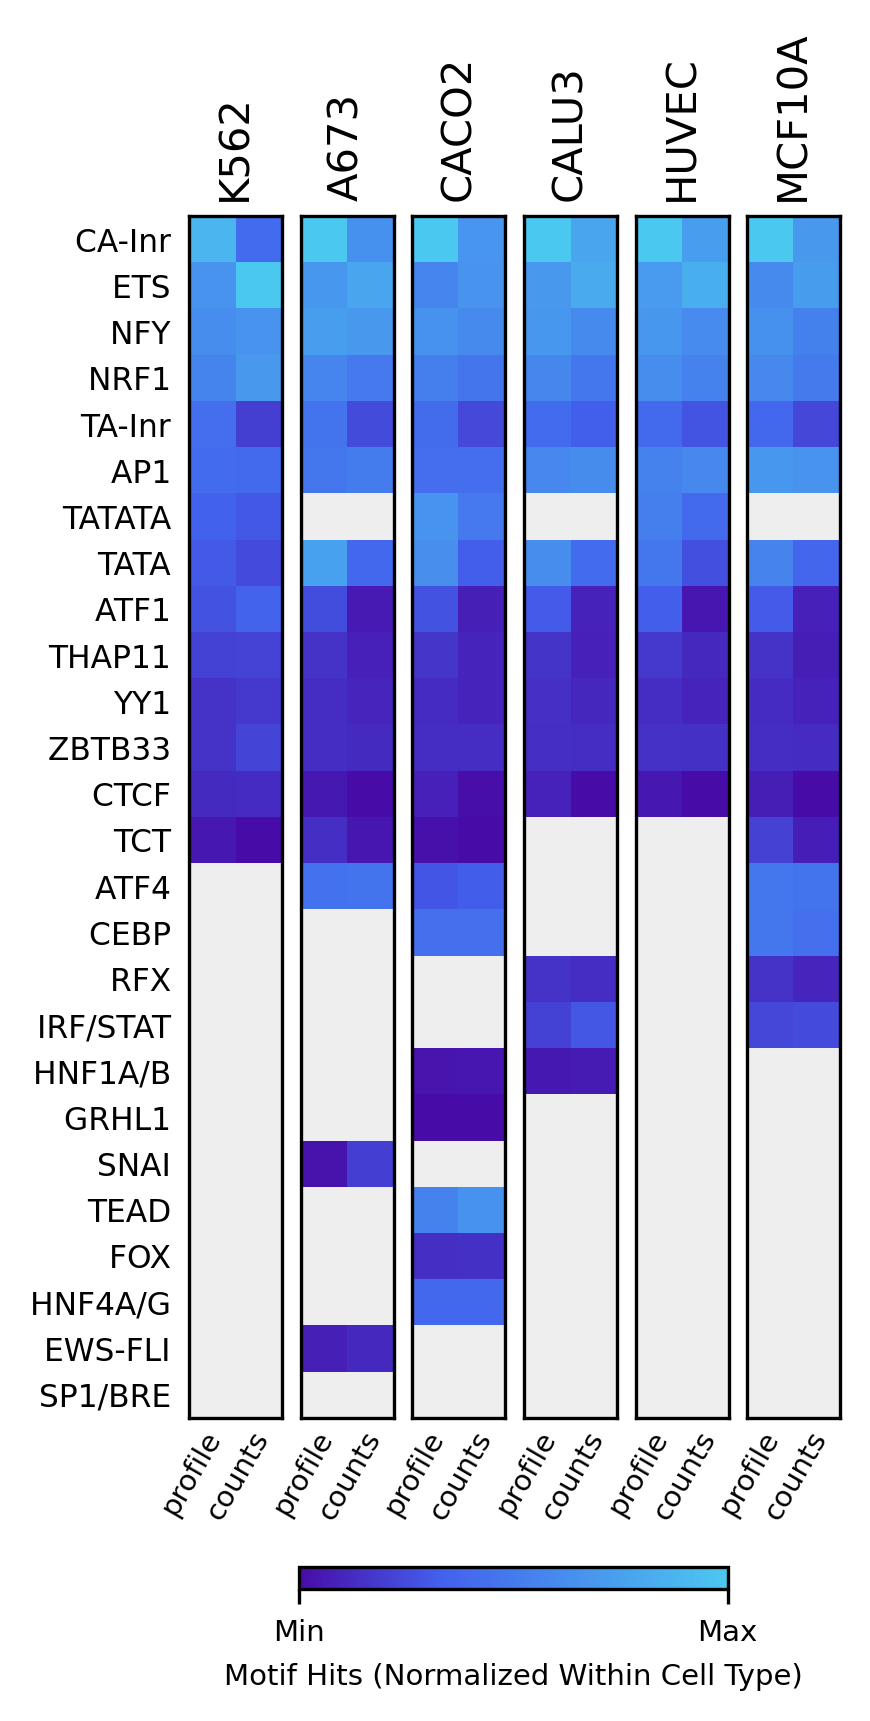

In [13]:
import matplotlib as mpl

def plot_modisco_hits_all_cell_types(all_motif_hit_counts,
                                     motif_names = motif_names,
                                     save_path=None):
    num_motifs = len(motif_names)
    tasks = ["profile", "counts"]
    
    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')
    
    # 2 = number of tasks
    heatmap_data = np.empty((2, len(cell_types), len(motif_names)))
    
    for task_i, task in enumerate(tasks):
        
        for cell_i, cell_type in enumerate(cell_types):
            hit_counts = all_motif_hit_counts[cell_type][task]

            # this will keep the order of motifs the same
            heatmap_col = [hit_counts[motif_name] for motif_name in motif_names]
            heatmap_data[task_i, cell_i, :] = np.array(heatmap_col)

    heatmap_data = np.swapaxes(heatmap_data, 0, 1)
    
    sort_by = np.copy(heatmap_data[0,0,:])
    for i in range(len(sort_by)):
        if np.isnan(sort_by[i]):
            sort_by[i] = np.sum(~ np.isnan(heatmap_data[:,0,i]))
    
    sort_order = np.argsort(sort_by)[::-1]
    
    heatmap_data = heatmap_data[:,:, sort_order]
    motif_names = np.array(motif_names)[sort_order]
        
    fig, axes = plt.subplots(1, len(cell_types), figsize=(2.8, 0.2 * num_motifs), dpi=300, sharey=True)
    
    for ax_i, cell_type in enumerate(cell_types):
        ax = axes[ax_i]
        ax.imshow(np.sqrt(heatmap_data[ax_i].T),
                  aspect = "auto", cmap=cmap)

        ax.set_xticks(np.arange(len(tasks)) - 0.45, tasks, fontsize=7, rotation=60)
        
        if ax_i == 0:
            ax.set_yticks(np.arange(len(motif_names)), [name + " "  for name in motif_names], fontsize=7.5)

        ax.tick_params(length=0, pad=2)

        ax.set_title(cell_type, fontsize=10, rotation=90)
    
    
    cb_ax = fig.add_axes([0.256, 0.0, 0.51, 0.014])
    
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=(0,1), orientation="horizontal", cax=cb_ax)
    cbar.set_ticklabels(["Min", "Max"], fontsize=7)
    cbar.set_label("Motif Hits (Normalized Within Cell Type)", fontsize=7)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        
            
plot_modisco_hits_all_cell_types(all_motif_hit_counts, motif_names,
                                 save_path = figures_dir + "celltypes_modisco_hitcounts.png")

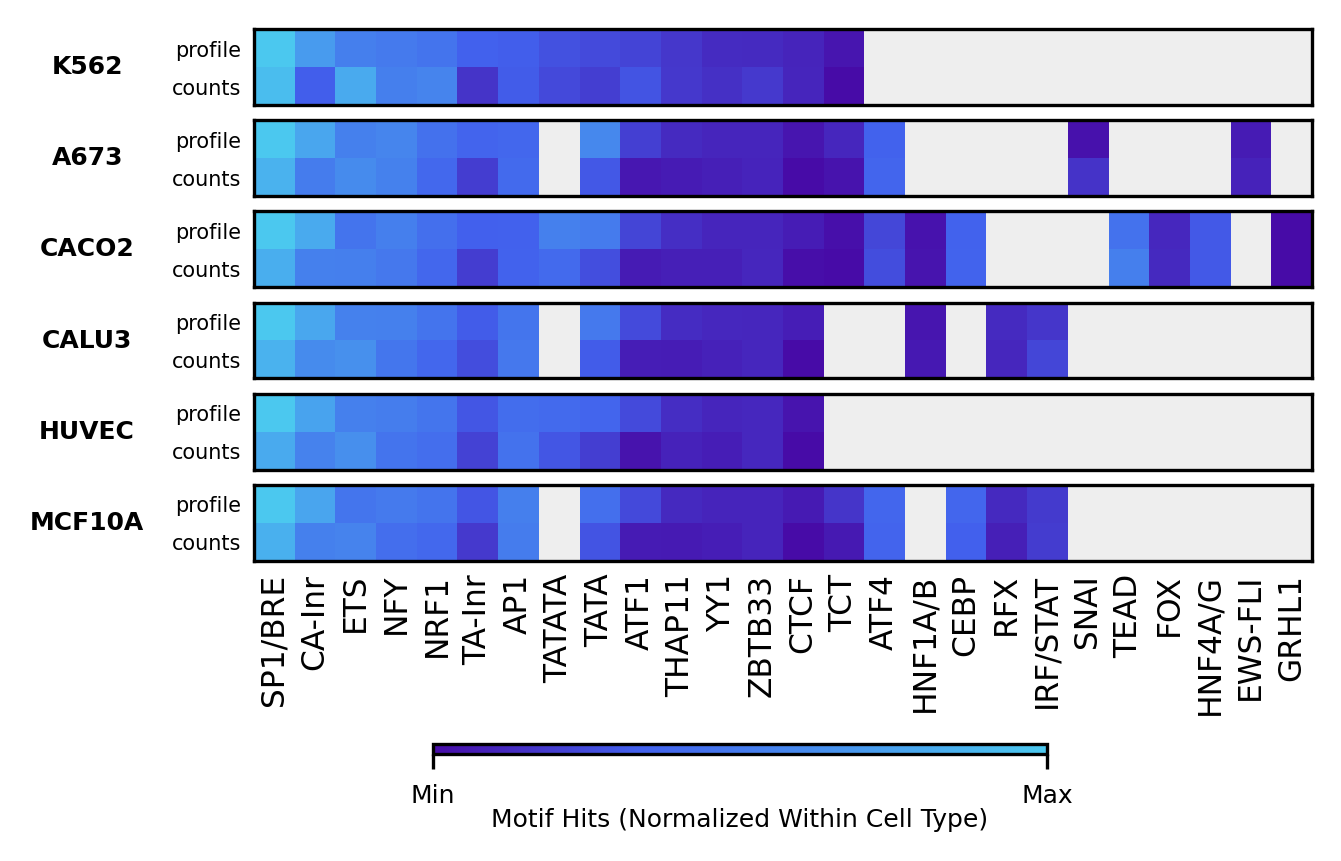

In [16]:
import matplotlib as mpl

def plot_modisco_hits_all_cell_types_wide(all_motif_hit_counts,
                                     motif_names = motif_names,
                                     save_path=None):
    num_motifs = len(motif_names)
    tasks = ["profile", "counts"]
    
    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')
    
    # 2 = number of tasks
    heatmap_data = np.empty((2, len(cell_types), len(motif_names)))
    
    for task_i, task in enumerate(tasks):
        
        for cell_i, cell_type in enumerate(cell_types):
            hit_counts = all_motif_hit_counts[cell_type][task]

            # this will keep the order of motifs the same
            heatmap_col = [hit_counts[motif_name] for motif_name in motif_names]
            heatmap_data[task_i, cell_i, :] = np.array(heatmap_col)

    heatmap_data = np.swapaxes(heatmap_data, 0, 1)
    
    sort_by = np.copy(heatmap_data[0,0,:])
    for i in range(len(sort_by)):
        if np.isnan(sort_by[i]):
            sort_by[i] = np.sum(~ np.isnan(heatmap_data[:,0,i]))
    
    sort_order = np.argsort(sort_by)[::-1]
    
    heatmap_data = heatmap_data[:,:, sort_order]
    motif_names = np.array(motif_names)[sort_order]
        
    fig, axes = plt.subplots(len(cell_types), figsize=(0.175 * num_motifs, 2.3),
                             dpi=300, sharex=True)
    
    for ax_i, cell_type in enumerate(cell_types):
        ax = axes[ax_i]
        ax.imshow(np.sqrt(heatmap_data[ax_i]),
                  aspect = "auto", cmap=cmap)

        ax.set_yticks(np.arange(len(tasks)), tasks,
                      fontsize=5)
        
        if ax_i == len(cell_types) - 1:
            ax.set_xticks(np.arange(len(motif_names)), motif_names,
                          fontsize=7.5, rotation=90)

        ax.tick_params(length=0, pad=3)

        # add the outer-y-axis-label looking text
        label_ax = ax.twinx()
        label_ax.spines[:].set_visible(False)
        label_ax.set_yticks([])
        label_ax.yaxis.set_label_position('left')
        label_ax.set_ylabel(cell_type, fontsize=6, labelpad=40,
                            rotation=0, y=0.35, weight="bold")
    
    
    cb_ax = fig.add_axes([0.256, -0.17, 0.45, 0.014])
    
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=(0,1), orientation="horizontal", cax=cb_ax)
    cbar.set_ticklabels(["Min", "Max"], fontsize=6)
    cbar.set_label("Motif Hits (Normalized Within Cell Type)", fontsize=6, labelpad=0)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)
    else:
        plt.show()
        
            
plot_modisco_hits_all_cell_types_wide(all_motif_hit_counts, motif_names,
                                 save_path = figures_dir + "celltypes_modisco_hitcounts_wide.png")